# Imoport Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import time
import keras
import math
import json 

from shutil import copy
from PIL import Image

sys.path.insert(1, '../../utils')
#from Nutrition5kDataPrep import prepare_data, create_dataset

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import datasets, layers, models
from keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import sklearn.metrics as sklm

# Load Data

In [ ]:
#drive.flush_and_unmount()

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/Nutrition5k")

Mounted at /content/drive


In [3]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    with open(filepath, 'r') as txt:
        paths = [read.strip()+'/rgb.png' for read in txt.readlines()]

    if not os.path.exists(dest):
        os.makedirs(dest)

    for food in paths:
        out = food.split('/')
        dest_name = out[0]+'.png'
        src_path = os.path.join(src,food)
        dest_path = os.path.join(dest,dest_name)

        if (not os.path.exists(dest_path)) and os.path.exists(src_path):
            # print("\nCopying images into ", dest_name)
            copy(os.path.join(src,food), os.path.join(dest,dest_name))

    print("Copying Done!")


def create_dataset(filenames, labels,
                   is_training=True,
                   img_size = 224, channels = 3, batch_size = 256, buffer_size = 1024):
  # 
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
    # Parse and preprocess observations in parallel
    dataset = dataset.map(lambda x, y: parse_function(x, y, img_size=img_size, channels=channels),
                          num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size=batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset
    
def parse_function(filename, label, img_size = 224, channels = 3):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_png(image_string, channels=channels)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [img_size, img_size])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [4]:
# Prepare train dataset
print("Creating train data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_train_ids.txt' # directory to rgb_train_ids.txt
src = './data/Nutrition5k/realsense_overhead'                     # directory to images 
dest = './data/Nutrition5k/train_rgb'                             # directory to train_rgb folder
prepare_data(filepath, src, dest)

# Prepare test dataset
print("Creating test data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_test_ids.txt' # directory to rgb_test_ids.txt
src = './data/Nutrition5k/realsense_overhead'                    # directory to images 
dest = './data/Nutrition5k/test_rgb'                             # directory to test_rgb folder
prepare_data(filepath, src, dest)

# read specified labels
labels = pd.read_csv('./data/Nutrition5k/193_ingredients/nutrition5k_193_ingr_calorie.csv')#.iloc[: , 1:]
labels = labels.rename(columns={"Unnamed: 0": "dish_id"})
labels['dish_id'] = labels['dish_id'] + '.png'
ingred = labels.iloc[: , 1:].columns

ingredients_with_categories = pd.read_csv("./data/Nutrition5k/193_ingredients/ingredients_with_categories.csv")

Creating train data...
Copying Done!
Creating test data...
Copying Done!


In [5]:
ingredients_with_categories

ingr_index               ingr   id  cal/g  fat(g)  carb(g)  protein(g)  \
0             0          olive oil  161  8.840   1.000    0.000       0.000   
1             1             garlic  122  1.490   0.005    0.330       0.064   
2             2             pepper  312  0.400   0.002    0.093       0.020   
3             3             onions   94  0.400   0.001    0.090       0.011   
4             4        lemon juice  520  0.170   0.000    0.056       0.004   
..          ...                ...  ...    ...     ...      ...         ...   
188         188              toast  287  3.131   0.042    0.555       0.130   
189         189        wheat bread  245  2.468   0.033    0.421       0.130   
190         190  mozzarella cheese  243  2.776   0.171    0.032       0.280   
191         191        brown sugar  154  3.800   0.000    0.980       0.001   
192         192              syrup   67  2.600   0.001    0.670       0.000   

     frequency  nonzero_mean        food_category  freq_category  \
0         1561     41.639315          fat_and_oil             10   
1          947      1.844471            vegetable             10   
2          723      0.553660  condiment_and_sauce             10   
3          686      3.026821            vegetable             10   
4          572      0.233524             beverage             10   
..         ...           ...                  ...            ...   
188          1    263.004000                grain              1   
189          1    202.376000                grain              1   
190          1     72.176000                dairy              1   
191          1     38.000000  condiment_and_sauce              1   
192          1     98.962500  condiment_and_sauce              1   

     mean_category  cluster_category  
0                6                 6  
1                2                 3  
2                1                 3  
3                2                 5  
4                1                 5  
..             ...               ...  
188             10                 1  
189             10                 1  
190              8                 8  
191              6                 4  
192              8                 8  

[193 rows x 13 columns]

In [ ]:
# change the names of labels from ingredients to categories(food_category, freq_category, mean_category_cluster_category)
#ing_cat_dict = ingredients_with_categories.set_index('ingr')["food_category"]
# ing_cat_dict
#labels = labels.rename(columns = ing_cat_dict)
#print(labels)

# Sum values in columns with the same column name
#labels = labels.groupby(labels.columns, axis = 1).sum()
#column_names = labels.columns.tolist()

# Move the 'dish_id' column to the first position
#column_names.insert(0, column_names.pop(column_names.index('dish_id')))

# Reorder the DataFrame columns
#labels = labels[column_names]
#print(labels)

In [6]:
labels

dish_id   olive oil    garlic    pepper    onions  \
0     dish_1561662216.png   28.673672  3.164916  0.084964  0.682869   
1     dish_1561662054.png  101.154334  4.480668  0.120286  2.409010   
2     dish_1562008979.png    6.823110  2.300097  0.154369  0.000000   
3     dish_1560455030.png    0.000000  0.000000  0.000000  0.000000   
4     dish_1558372433.png    0.000000  0.000000  0.000000  0.000000   
...                   ...         ...       ...       ...       ...   
3257  dish_1563295334.png    0.000000  0.000000  0.000000  0.000000   
3258  dish_1566329234.png    3.600125  0.000000  0.000000  0.814508   
3259  dish_1562691737.png   19.620486  0.000000  0.000000  0.000000   
3260  dish_1558458496.png    0.000000  0.000000  0.000000  0.000000   
3261  dish_1568664931.png   55.466668  0.876470  0.000000  0.000000   

      lemon juice  arugula   parsley  cherry tomatoes  spinach (raw)  ...  \
0        0.145110      0.0  0.079170              0.0       0.000000  ...   
1        0.511915      0.0  0.279295              0.0       0.000000  ...   
2        0.262427      0.0  0.286354              0.0       0.000000  ...   
3        0.000000      0.0  0.000000              9.9       0.000000  ...   
4        0.000000      0.0  0.000000              0.0       0.000000  ...   
...           ...      ...       ...              ...            ...  ...   
3257     0.000000      0.0  0.000000              0.0       0.000000  ...   
3258     0.000000      0.0  0.000000              0.0       0.000000  ...   
3259     0.000000      0.0  0.000000              0.0       0.000000  ...   
3260     0.000000      0.0  0.000000              0.0       0.000000  ...   
3261     0.000000      0.0  0.000000              0.0       7.215687  ...   

      succotash  pasta salad  balsamic vinegar  orange with peel  \
0           0.0          0.0               0.0               0.0   
1           0.0          0.0               0.0               0.0   
2           0.0          0.0               0.0               0.0   
3           0.0          0.0               0.0               0.0   
4           0.0          0.0               0.0               0.0   
...         ...          ...               ...               ...   
3257        0.0          0.0               0.0               0.0   
3258        0.0          0.0               0.0               0.0   
3259        0.0          0.0               0.0               0.0   
3260        0.0          0.0               0.0               0.0   
3261        0.0          0.0               0.0               0.0   

      banana with peel  toast  wheat bread  mozzarella cheese  brown sugar  \
0                  0.0    0.0          0.0                0.0          0.0   
1                  0.0    0.0          0.0                0.0          0.0   
2                  0.0    0.0          0.0                0.0          0.0   
3                  0.0    0.0          0.0                0.0          0.0   
4                  0.0    0.0          0.0                0.0          0.0   
...                ...    ...          ...                ...          ...   
3257               0.0    0.0          0.0                0.0          0.0   
3258               0.0    0.0          0.0                0.0          0.0   
3259               0.0    0.0          0.0                0.0          0.0   
3260               0.0    0.0          0.0                0.0          0.0   
3261               0.0    0.0          0.0                0.0          0.0   

      syrup  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
3257    0.0  
3258    0.0  
3259    0.0  
3260    0.0  
3261    0.0  

[3262 rows x 194 columns]

# Data Preparation

## Add Binary Labels

In [7]:
def add_binary_labels(ds):
  ingredients = ds.columns[1:]
  ds.columns = [ds.columns[0]] + [col + '_calories' for col in ds.columns[1:]]
  for i in ingredients: 
    col_name = f'{i}_calories'
    binary_col_name = f'{i}_binary'
    threshold = 0 # Change this to your desired threshold
    ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
  return ds

labels = add_binary_labels(labels)

<ipython-input-7-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
<ipython-input-7-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
<ipython-input-7-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [10]:
labels

dish_id  olive oil_calories  garlic_calories  \
0     dish_1561662216.png           28.673672         3.164916   
1     dish_1561662054.png          101.154334         4.480668   
2     dish_1562008979.png            6.823110         2.300097   
3     dish_1560455030.png            0.000000         0.000000   
4     dish_1558372433.png            0.000000         0.000000   
...                   ...                 ...              ...   
3257  dish_1563295334.png            0.000000         0.000000   
3258  dish_1566329234.png            3.600125         0.000000   
3259  dish_1562691737.png           19.620486         0.000000   
3260  dish_1558458496.png            0.000000         0.000000   
3261  dish_1568664931.png           55.466668         0.876470   

      pepper_calories  onions_calories  lemon juice_calories  \
0            0.084964         0.682869              0.145110   
1            0.120286         2.409010              0.511915   
2            0.154369         0.000000              0.262427   
3            0.000000         0.000000              0.000000   
4            0.000000         0.000000              0.000000   
...               ...              ...                   ...   
3257         0.000000         0.000000              0.000000   
3258         0.000000         0.814508              0.000000   
3259         0.000000         0.000000              0.000000   
3260         0.000000         0.000000              0.000000   
3261         0.000000         0.000000              0.000000   

      arugula_calories  parsley_calories  cherry tomatoes_calories  \
0                  0.0          0.079170                       0.0   
1                  0.0          0.279295                       0.0   
2                  0.0          0.286354                       0.0   
3                  0.0          0.000000                       9.9   
4                  0.0          0.000000                       0.0   
...                ...               ...                       ...   
3257               0.0          0.000000                       0.0   
3258               0.0          0.000000                       0.0   
3259               0.0          0.000000                       0.0   
3260               0.0          0.000000                       0.0   
3261               0.0          0.000000                       0.0   

      spinach (raw)_calories  ...  succotash_binary  pasta salad_binary  \
0                   0.000000  ...                 0                   0   
1                   0.000000  ...                 0                   0   
2                   0.000000  ...                 0                   0   
3                   0.000000  ...                 0                   0   
4                   0.000000  ...                 0                   0   
...                      ...  ...               ...                 ...   
3257                0.000000  ...                 0                   0   
3258                0.000000  ...                 0                   0   
3259                0.000000  ...                 0                   0   
3260                0.000000  ...                 0                   0   
3261                7.215687  ...                 0                   0   

      balsamic vinegar_binary  orange with peel_binary  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   
...                       ...                      ...   
3257                        0                        0   
3258                        0                        0   
3259                        0                        0   
3260                        0                        0   
3261                        0                        0   

      banana with

In [11]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

#X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
#X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

## Scaling: std-mean 

In [13]:
# scale labels by std and mean of training ingredients
std_by_label = pd.DataFrame(y_train).describe().iloc[2]
print(std_by_label)
mean_by_label = pd.DataFrame(y_train).describe().iloc[1]
print(mean_by_label)
for idx,i in enumerate(labels.columns[1:194]):
    labels[i] = labels[i].apply(lambda x: (x - mean_by_label[idx]) / std_by_label[idx])

0      37.132144
1       1.447911
2       0.525674
3       2.604437
4       0.165839
         ...    
381     0.019052
382     0.019052
383     0.019052
384     0.019052
385     0.019052
Name: std, Length: 386, dtype: float64
0      20.149177
1       0.550192
2       0.129656
3       0.648579
4       0.043325
         ...    
381     0.000363
382     0.000363
383     0.000363
384     0.000363
385     0.000363
Name: mean, Length: 386, dtype: float64


## Scaling: Min-max

In [ ]:
# min-max normalization
max_by_label = pd.DataFrame(y_train).describe().iloc[-1]
#print(max_by_label)
min_by_label = pd.DataFrame(y_train).describe().iloc[3]
#print(min_by_label)
for idx,i in enumerate(labels.columns[1:11]):
    labels[i] = labels[i].apply(lambda x: (x - min_by_label[idx]) / (max_by_label[idx] - min_by_label[idx]))

In [ ]:
# to calculate relative error, we need std
std_by_label = pd.DataFrame(y_train).describe().iloc[2]

## Split datasets

In [14]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

# define some params
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

# create datasets
train_ds = create_dataset(X_train, y_train, is_training=True,
                          img_size = IMG_SIZE, channels = CHANNELS,
                          batch_size = BATCH_SIZE,
                          buffer_size = SHUFFLE_BUFFER_SIZE)

val_ds = create_dataset(X_val, y_val,
                        img_size = IMG_SIZE, channels = CHANNELS,
                        batch_size = BATCH_SIZE, buffer_size = SHUFFLE_BUFFER_SIZE)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (64, 224, 224, 3)
Shape of labels array: (64, 386)


## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

Text(0.5, 1.0, 'Augmented Image')

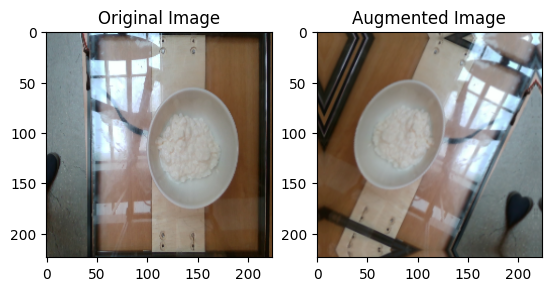

In [ ]:
sample_batch = next(iter(train_ds))
sample_image = sample_batch[0][0]
sample_label = sample_batch[1][0]

plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
augmented_image = data_augmentation(sample_image)
plt.imshow(augmented_image.numpy())
plt.title("Augmented Image")

In [19]:
# resize the data
#train_ds = train_ds.map(lambda x,y:(data_augmentation(x), y))
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))
val_ds = val_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))

# Classification + Regression

## Metrics

In [15]:
# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
class self_Accuracy(tf.keras.metrics.Metric):

    def __init__(self, label, name='accuracy_by_label_'):
        super(self_Accuracy, self).__init__(name=name)
        self.label = label
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Called at the end of each batch:
        calculates number of correct prediction and total number of predictions
        """
        # number of correct predictions
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        self.correct.assign_add(tf.keras.metrics.binary_accuracy(tf.cast(y_true_bin[:,self.label],tf.float32), 
                                tf.cast(y_pred_bin[:,self.label],tf.float32)) 
                                * tf.cast(tf.size(y_pred_bin),tf.float32))
        # total number of predictions 
        self.total.assign_add(tf.cast(tf.size(y_pred_bin),tf.float32))
        
    def result(self):
        return self.correct / self.total
    
    def reset_state(self):
        """
        reset variables between epochs
        """
        self.correct.assign(0)
        self.total.assign(0)

class self_MSE(tf.keras.metrics.Metric):
    """
    Calculates total MSE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MSE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mse_by_label_', **kwargs):
        super(self_MSE, self).__init__(name=name, **kwargs)
        # when scale is standardization, param1 is std, param2 is mean
        # when scale is normalization, param1 is min, param2 is max
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mse = self.add_weight(name='mse', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = tf.square(z_true - y_pred_bin * z_pred)
        mse = tf.reduce_mean(regression_loss, axis=0)
        self.mse.assign_add(mse)

    def result(self):
        return self.mse

    def reset_state(self):
        self.mse.assign(0.)

class self_MAE(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mae_by_label_', **kwargs):
        super(self_MAE, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mae = self.add_weight(name='mae', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = tf.abs(z_true - y_pred_bin * z_pred)
        mae = tf.reduce_mean(regression_loss, axis=0)
        self.mae.assign_add(mae)

    def result(self):
        return self.mae

    def reset_state(self):
        self.mae.assign(0.)


class self_relative_error(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, std, param1, param2, scale = "standardization", name='relative_error_by_label_', **kwargs):
        super(self_relative_error, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.std = std
        self.class_id = class_id
        self.relative_error= self.add_weight(name='relative_error', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = (tf.abs(z_true - y_pred_bin * z_pred))/ self.std[self.class_id]
        relative_error = tf.reduce_mean(regression_loss, axis=0)
        self.relative_error.assign_add(relative_error)

    def result(self):
        return self.relative_error

    def reset_state(self):
        self.relative_error.assign(0.)

## Custom Loss function

In [16]:
def combined_loss_mse(y_true, y_pred):

  z_true = y_true[:, :y_true.shape[1]//2]
  z_pred = y_pred[:, :y_true.shape[1]//2]
  
  y_true_bin = y_true[:, y_true.shape[1]//2:]
  y_pred_logit = y_pred[:, y_true.shape[1]//2:]
  y_pred_prob = tf.nn.sigmoid(y_pred_logit)
  y_pred_bin = tf.where(y_pred_prob>0.5,1,0)

    # Compute cross-entropy loss
  ce_loss= tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true_bin, logits = y_pred_logit)
  #ce_loss = tf.keras.losses.binary_crossentropy(y_true_bin, y_pred_prob)

    # Compute regression loss only for predicted active ingredients
  #regression_loss = tf.square(z_true - tf.cast(y_pred_bin, tf.float32) * z_pred)  
  regression_loss = tf.cast(y_pred_bin, tf.float32) * tf.square(z_true - z_pred)
  # reg_loss = tf.reduce_sum(regression_loss, axis=1)

    # Combine the losses
  loss = tf.reduce_mean(ce_loss) + tf.reduce_mean(regression_loss)
  return loss


def combined_loss_mae(y_true, y_pred):

  z_true = y_true[:, :y_true.shape[1]//2]
  z_pred = y_pred[:, :y_true.shape[1]//2]
  
  y_true_bin = y_true[:, y_true.shape[1]//2:]
  y_pred_logit = y_pred[:, y_true.shape[1]//2:]
  y_pred_prob = tf.nn.sigmoid(y_pred_logit)
  y_pred_bin = tf.where(y_pred_prob>0.5,1,0)

    # Compute cross-entropy loss
  ce_loss= tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true_bin, logits = y_pred_logit)
  #ce_loss = tf.keras.losses.binary_crossentropy(y_true_bin, y_pred_prob)

    # Compute regression loss only for predicted active ingredients
  regression_loss = tf.abs(z_true - tf.cast(y_pred_bin, tf.float32) * z_pred)
  # regression_loss = tf.cast(y_pred_bin, tf.float32) * tf.abs(z_true - z_pred)
  # reg_loss = tf.reduce_sum(regression_loss, axis=1)

    # Combine the losses
  loss = tf.reduce_mean(ce_loss) + tf.reduce_mean(regression_loss)
  return loss

## Compile and Fit Model

In [20]:
input_shape = (75, 75, 3)
num_of_ingre = 193

# Load the InceptionV3 model with pretrained weights
base_model = InceptionV3(weights='imagenet', input_shape = input_shape, include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer for binary classification
binary_preds = Dense(num_of_ingre, name='binary_preds')(x)

# Add a fully-connected layer for regression
regression_preds = Dense(num_of_ingre, name='regression_preds')(x)

combined_preds = Concatenate(name='combined_preds')([binary_preds, regression_preds])

model = Model(inputs=base_model.input, outputs=combined_preds)

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.0001, decay_steps=1000)
optimizer_adam_cos_decay = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
scaling_method = "standardization"
param1 = std_by_label
param2 = mean_by_label

#Compile the model
model.compile(optimizer=optimizer_adam_cos_decay, loss = combined_loss_mae, 
              metrics=[self_Accuracy(label = i, name='acc_{}'.format(i)) for i in range(num_of_ingre)]+
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mse_{}'.format(i)) for i in range(num_of_ingre)] +
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mae_{}'.format(i)) for i in range(num_of_ingre)] +
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = None, name='relative_error_{}'.format(i)) for i in range(num_of_ingre)] + 
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mse_scaled_back_{}'.format(i)) for i in range(num_of_ingre)]+
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mae_scaled_back_{}'.format(i)) for i in range(num_of_ingre)] +   
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = scaling_method, name='relative_error_scaled_back_{}'.format(i)) for i in range(num_of_ingre)]
              )

In [21]:
EPOCHS = 30
#Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
44/44 [==============================] - 307s 3s/step - loss: 0.7237 - acc_0: 0.5456 - acc_1: 0.6425 - acc_2: 0.6178 - acc_3: 0.6407 - acc_4: 0.6555 - acc_5: 0.8163 - acc_6: 0.7456 - acc_7: 0.4628 - acc_8: 0.8102 - acc_9: 0.8138 - acc_10: 0.8505 - acc_11: 0.8374 - acc_12: 0.6955 - acc_13: 0.8207 - acc_14: 0.8200 - acc_15: 0.7855 - acc_16: 0.8240 - acc_17: 0.8443 - acc_18: 0.9031 - acc_19: 0.8980 - acc_20: 0.6145 - acc_21: 0.8951 - acc_22: 0.8639 - acc_23: 0.8653 - acc_24: 0.8740 - acc_25: 0.8704 - acc_26: 0.7913 - acc_27: 0.7067 - acc_28: 0.8040 - acc_29: 0.8693 - acc_30: 0.8250 - acc_31: 0.8309 - acc_32: 0.8868 - acc_33: 0.9038 - acc_34: 0.8410 - acc_35: 0.6407 - acc_36: 0.8853 - acc_37: 0.8316 - acc_38: 0.8181 - acc_39: 0.9256 - acc_40: 0.9310 - acc_41: 0.8258 - acc_42: 0.8871 - acc_43: 0.8519 - acc_44: 0.7394 - acc_45: 0.7198 - acc_46: 0.8893 - acc_47: 0.9238 - acc_48: 0.8388 - acc_49: 0.8766 - acc_50: 0.8236 - acc_51: 0.9332 - acc_52: 0.7539 - acc_53: 0.8134 - acc_54: 0.

## Plot Results

In [ ]:
train_num_of_batch = math.ceil(len(X_train)/BATCH_SIZE)
val_num_of_batch = math.ceil(len(X_val)/BATCH_SIZE)
d = history.history
df_new = pd.DataFrame({'epoch':[],'accuracy_train':[],
                   'accuracy_val':[], 'mse_train':[],
                   'mse_val':[], 'mae_train':[],
                   'mae_val':[], 'mse_scaled_back_train':[],
                   'mse_scaled_back_val':[], 'mae_scaled_back_train':[],
                   'mae_scaled_back_val':[], 'relative_error_train':[], 'relative_error_val':[], 'relative_error_scaled_back_train':[], 
                   'relative_error_scaled_back_val':[], 'loss': [], 'val_loss':[],
                    'label':[]})

for idx in range(num_of_ingre):
    for ep in range(EPOCHS):
        
        acc_train = d['acc_{}'.format(idx)][ep]
        acc_val = d['val_acc_{}'.format(idx)][ep]
        mse_train = d['mse_{}'.format(idx)][ep]/train_num_of_batch
        mse_val = d['val_mse_{}'.format(idx)][ep]/val_num_of_batch
        mae_train = d['mae_{}'.format(idx)][ep]/train_num_of_batch
        mae_val = d['val_mae_{}'.format(idx)][ep]/val_num_of_batch
        mse_scaled_back_train = d['mse_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mse_scaled_back_val = d['val_mse_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        mae_scaled_back_train = d['mae_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mae_scaled_back_val = d['val_mae_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_train = d['relative_error_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_val = d['val_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_scaled_back_train = d['relative_error_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_scaled_back_val = d['val_relative_error_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        loss_train = d['loss'][ep]
        loss_val = d['val_loss'][ep]

        temp = pd.DataFrame({'epoch':[ep+1],'accuracy_train':[acc_train],
                             'accuracy_val':[acc_val], 'mse_train':[mse_train],
                             'mse_val':[mse_val], 'mae_train':[mae_train],
                             'mae_val':[mae_val], 'mse_scaled_back_train':[mse_scaled_back_train],
                   'mse_scaled_back_val':[mse_scaled_back_val], 'mae_scaled_back_train':[mae_scaled_back_train],
                   'mae_scaled_back_val':[mae_scaled_back_val], 'relative_error_train':[relative_error_train], 'relative_error_val':[relative_error_val], 'relative_error_scaled_back_train':[ relative_error_scaled_back_train], 
                   'relative_error_scaled_back_val':[relative_error_scaled_back_val], 
                   'loss': [loss_train], 'val_loss':[loss_val],
                             'label':[idx]})
        df_new = df_new.append(temp, ignore_index=True)

df_new.label = df_new.label.astype(str)

In [ ]:
df_new

epoch  accuracy_train  accuracy_val  mse_train   mse_val  mae_train  \
0       1.0        0.512160      0.589744   1.108086  0.955233   0.653200   
1       2.0        0.619238      0.743590   1.027071  1.028321   0.677963   
2       3.0        0.733938      0.739645   0.984551  0.953440   0.684387   
3       4.0        0.791289      0.777120   0.869451  0.957192   0.635799   
4       5.0        0.821053      0.790927   0.797372  0.949028   0.599150   
...     ...             ...           ...        ...       ...        ...   
5785   26.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5786   27.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5787   28.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5788   29.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5789   30.0        0.999637      1.000000   3.477833  0.000000   0.035143   

       mae_val  mse_scaled_back_train  mse_scaled_back_val  \
0     0.647169            1716.057706          1534.098633   
1     0.668983            1620.294389          1318.107056   
2     0.656998            1380.932972          1261.040039   
3     0.654708            1125.907759          1252.770020   
4     0.650014            1013.854847          1251.361816   
...        ...                    ...                  ...   
5785  0.000000              12.369174             0.001290   
5786  0.000000              12.369170             0.001290   
5787  0.000000              12.369173             0.001290   
5788  0.000000              12.369171             0.001290   
5789  0.000000              12.369171             0.001290   

      mae_scaled_back_train  mae_scaled_back_val  relative_error_train  \
0                 21.338409            18.633350              0.017591   
1                 19.625760            18.021509              0.018258   
2                 18.398497            17.679913              0.018431   
3                 15.668411            16.589924              0.017123   
4                 14.220305            15.930940              0.016136   
...                     ...                  ...                   ...   
5785               0.102181             0.035921              0.018639   
5786               0.102181             0.035921              0.018639   
5787               0.102181             0.035921              0.018639   
5788               0.102181             0.035921              0.018639   
5789               0.102181             0.035921              0.018639   

      relative_error_val  relative_error_scaled_back_train  \
0               0.017429                          0.574661   
1               0.018016                          0.528538   
2               0.017694                          0.495487   
3               0.017632                          0.421964   
4               0.017505                          0.382965   
...                  ...                               ...   
5785            0.000000                          0.054195   
5786            0.000000                          0.054195   
5787            0.000000                          0.054195   
5788            0.000000                          0.054195   
5789            0.000000                          0.054195   

      relative_error_scaled_back_val      loss  val_loss  label  
0                           0.501812  1.765054  1.708954    0.0  
1                           0.485334  1.414984  1.618106    0.0  
2                           0.476135  1.334134  1.512640    0.0  
3                           0.446781  1.320046  1.385080    0.0  
4                           0.429034  1.310787  1.332783    0.0  
...                              ...       ...       ...    ...  
5785                        0.019052  1.168621  1.285066  192.0  
5786                        0.019052  1.166859  1.285212  192.0  
5787                        0.019052  1.167361  1.285024  192.0  
5788                        0.019052  1.16

In [38]:
category = "cluster_category"
ing_cat = ingredients_with_categories[["ingr_index", category]]
#print(ing_cat)
df_new['label'] = df_new['label'].astype(float)
merged_df = pd.merge(df_new, ing_cat, left_on='label', right_on = "ingr_index")
#print(merged_df)
mean_values = merged_df.groupby([category, 'epoch'])['accuracy_train', 'accuracy_val', 
                                                            'mse_train', 'mse_val', 'mae_train', 'mae_val', 
                                                            'mse_scaled_back_train', 'mse_scaled_back_val', 
                                                            'mae_scaled_back_train', 'mae_scaled_back_val', 
                                                            'relative_error_train', 'relative_error_val', 
                                                            'relative_error_scaled_back_train', 'relative_error_scaled_back_val'].mean().reset_index()
print(mean_values)
mean_values[category] = mean_values[category].astype('category')

     cluster_category  epoch  accuracy_train  accuracy_val  mse_train  \
0                   1    1.0        0.859006      0.897929   0.995257   
1                   1    2.0        0.987908      0.989892   0.978617   
2                   1    3.0        0.991765      0.992850   0.978138   
3                   1    4.0        0.991765      0.992973   1.002417   
4                   1    5.0        0.991765      0.993097   1.047711   
..                ...    ...             ...           ...        ...   
265                 9   26.0        0.942488      0.883629   0.657042   
266                 9   27.0        0.941762      0.883191   0.738754   
267                 9   28.0        0.941077      0.884068   0.668992   
268                 9   29.0        0.941238      0.883629   0.662721   
269                 9   30.0        0.942166      0.884287   0.666485   

      mse_val  mae_train   mae_val  mse_scaled_back_train  \
0    0.671401   0.159142  0.135899             592.671593   
1

<ipython-input-38-61839700cfd4>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_values = merged_df.groupby([category, 'epoch'])['accuracy_train', 'accuracy_val',


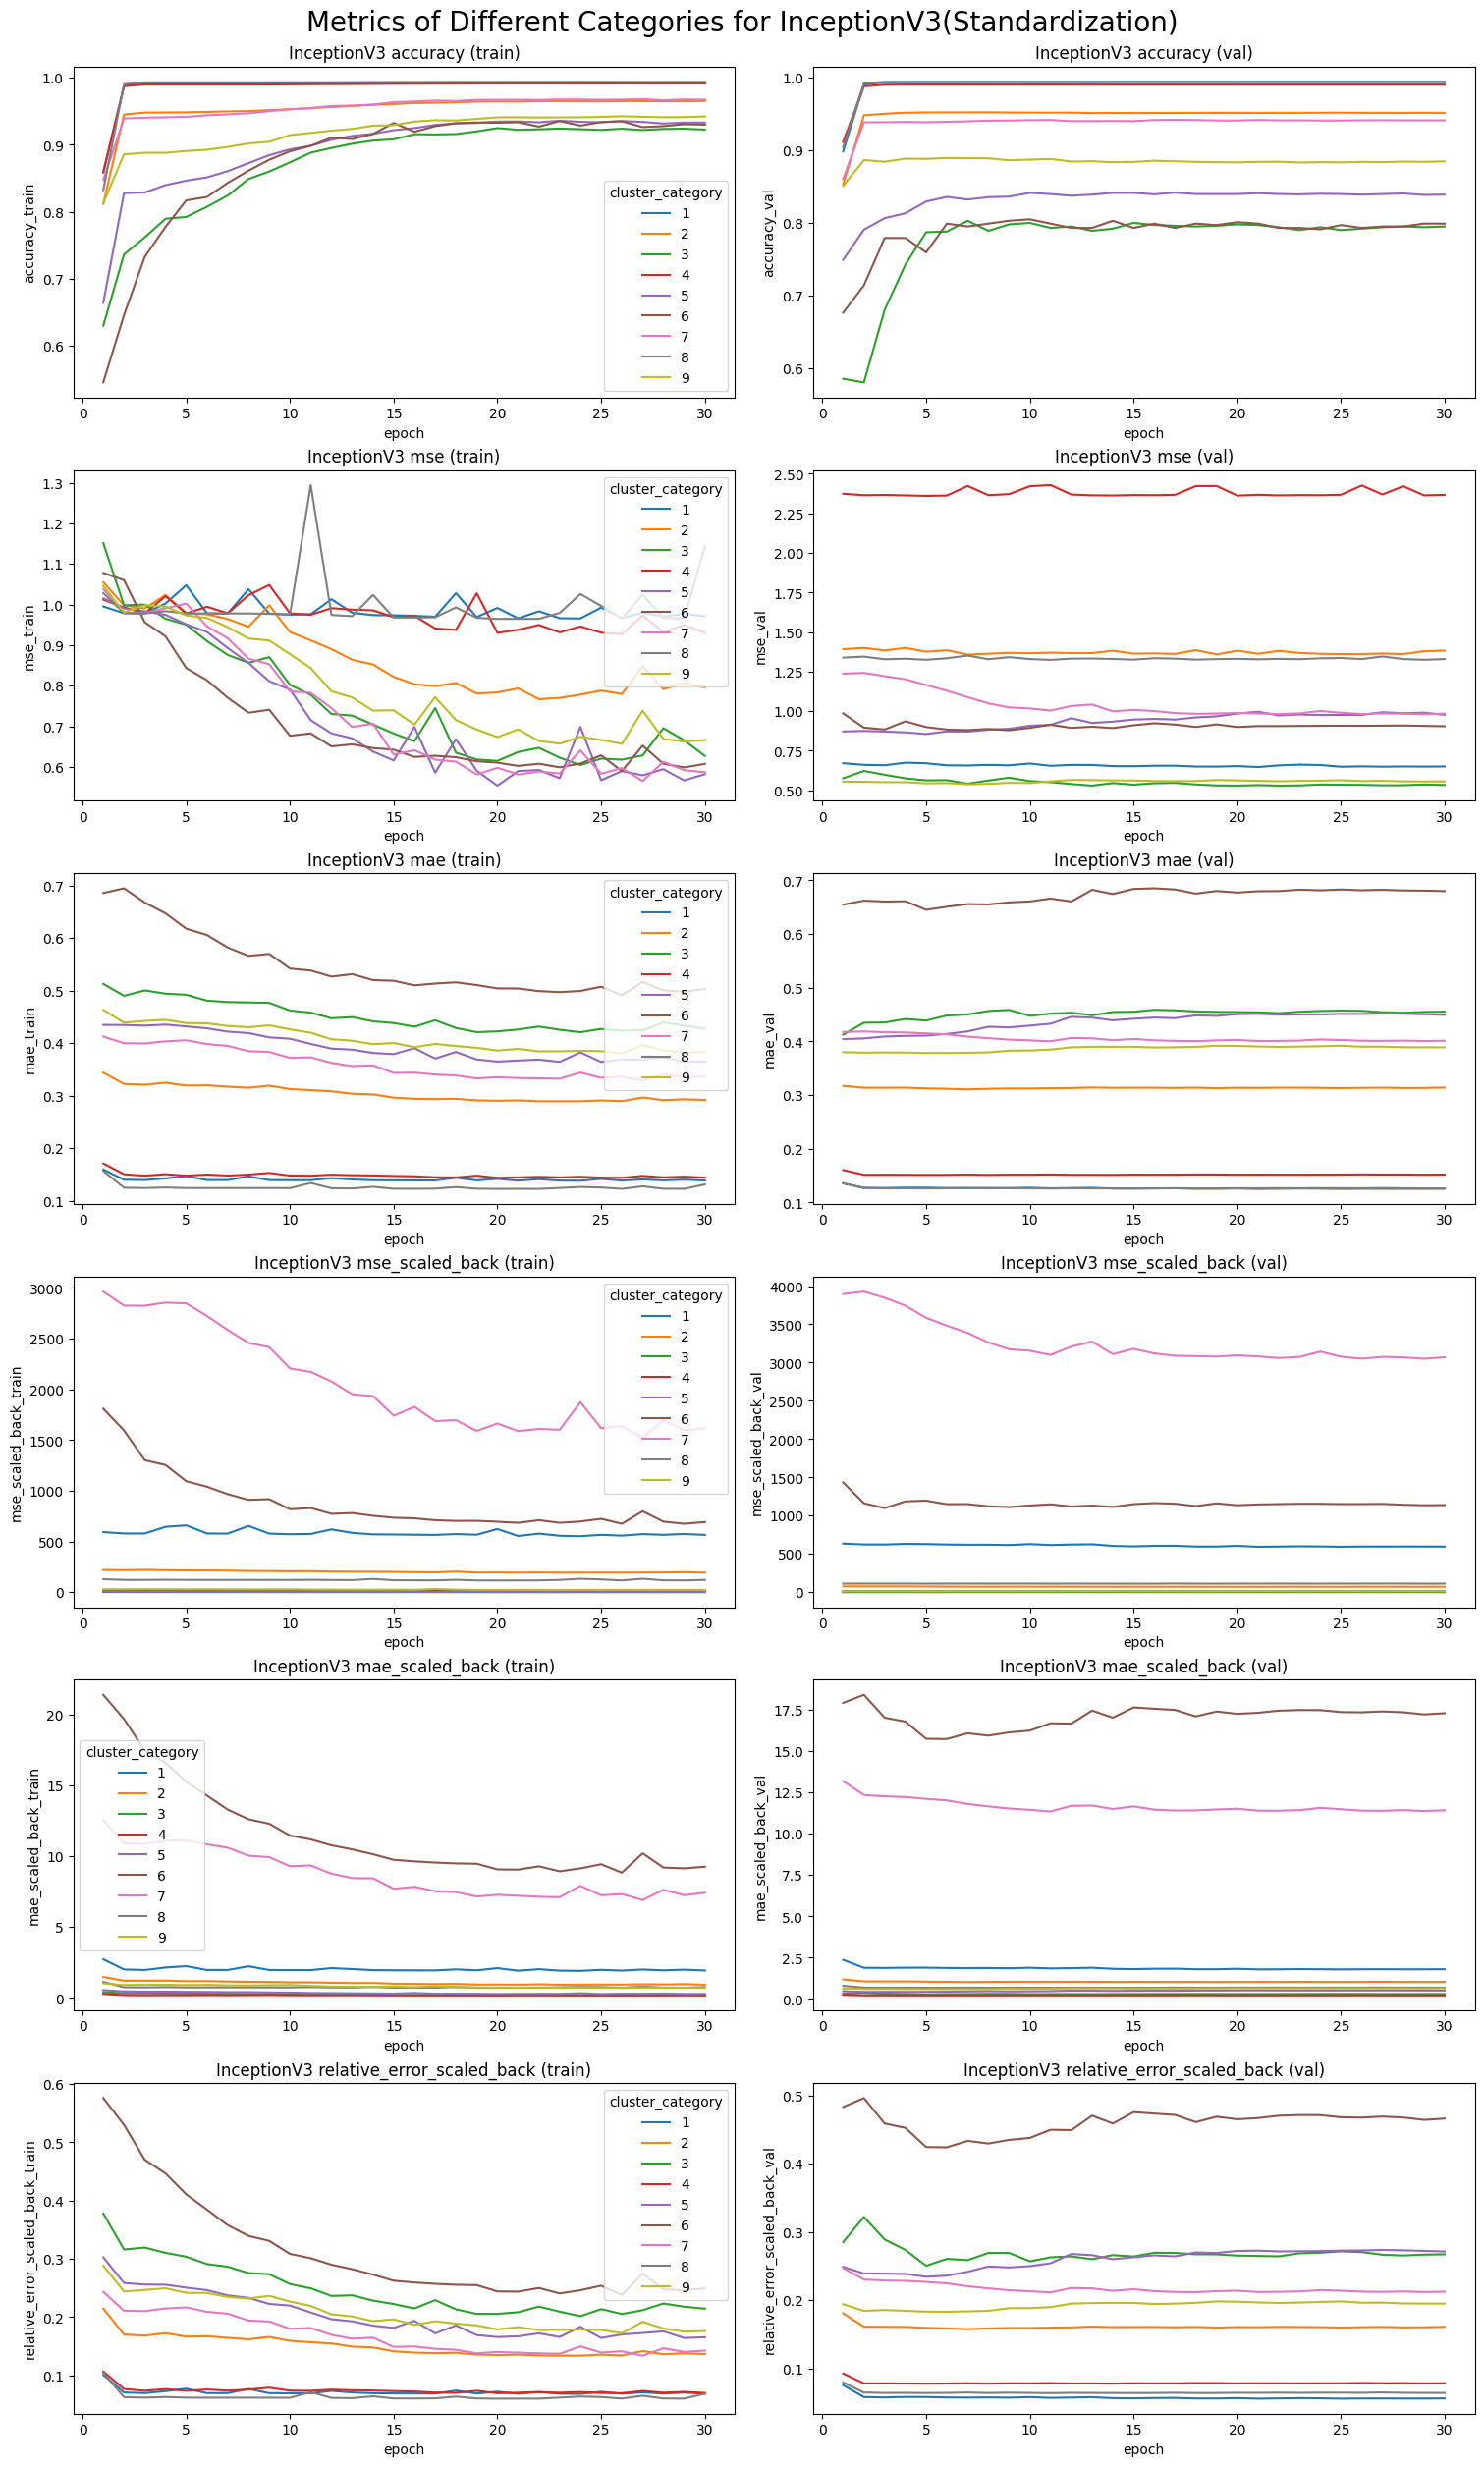

In [39]:
import seaborn as sns
fig, axis = plt.subplots(6, 2, figsize=(15, 25), constrained_layout = True)
metrics = ['accuracy', "mse", "mae", "mse_scaled_back", "mae_scaled_back", "relative_error_scaled_back"]
datasets = ['train', 'val']
for i in range(6):
    for j in range(2):
        if j == 1:
            sns.lineplot(data=mean_values, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=False, hue=category, ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))
        else:
            sns.lineplot(data=mean_values, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=True, hue=category, ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))

fig.suptitle('Metrics of Different Categories for InceptionV3(Standardization)', fontsize=20);

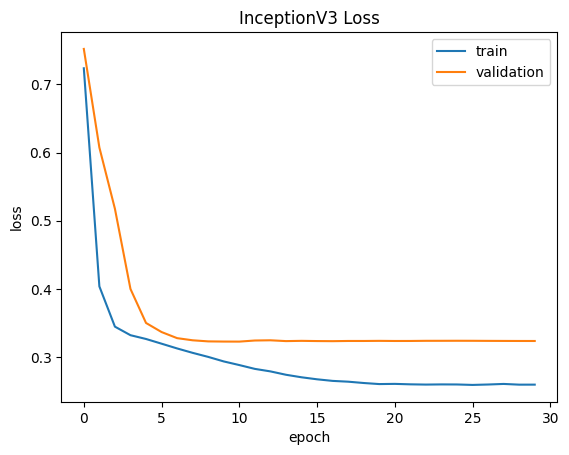

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

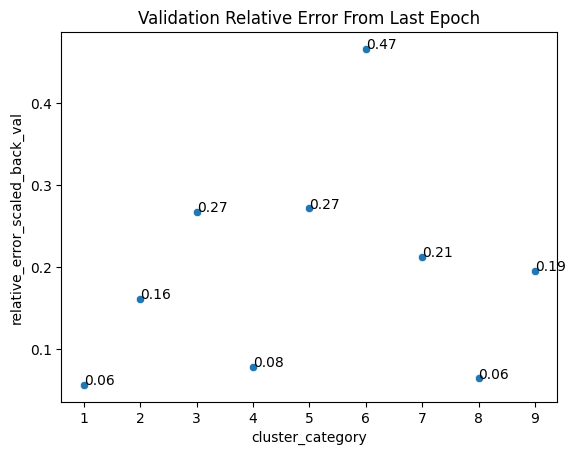

In [40]:
selected_df = mean_values[mean_values['epoch'] == EPOCHS]
sns.scatterplot(data=selected_df, x=category, y="relative_error_scaled_back_val")
for index, row in selected_df.iterrows():
    plt.text(row[category], row["relative_error_scaled_back_val"], str(round(row["relative_error_scaled_back_val"],2)))
plt.title('Validation Relative Error From Last Epoch')
#plt.xticks(rotation=90)
plt.show()

In [ ]:
df_new

epoch  accuracy_train  accuracy_val  mse_train   mse_val  mae_train  \
0       1.0        0.590200      0.631164   1.046495  1.009769   0.668991   
1       2.0        0.697641      0.733728   1.030502  0.962862   0.684106   
2       3.0        0.761162      0.767258   0.927267  0.917936   0.655294   
3       4.0        0.801815      0.788955   0.875247  0.849304   0.634760   
4       5.0        0.822142      0.783037   0.822824  0.856554   0.615528   
...     ...             ...           ...        ...       ...        ...   
5785   26.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5786   27.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5787   28.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5788   29.0        0.999637      1.000000   3.477833  0.000000   0.035143   
5789   30.0        0.999637      1.000000   3.477833  0.000000   0.035143   

       mae_val  mse_scaled_back_train  mse_scaled_back_val  \
0     0.662578            1615.392756          1480.303101   
1     0.686837            1474.553445          1215.215576   
2     0.672503            1232.936435          1142.467896   
3     0.641888            1126.789151          1062.443970   
4     0.650522            1041.781161          1084.327881   
...        ...                    ...                  ...   
5785  0.000000              12.369170             0.001290   
5786  0.000000              12.369173             0.001290   
5787  0.000000              12.369173             0.001290   
5788  0.000000              12.369178             0.001290   
5789  0.000000              12.369173             0.001290   

      mae_scaled_back_train  mae_scaled_back_val  relative_error_train  \
0                 19.638024            18.405207              0.018016   
1                 18.789949            19.310432              0.018424   
2                 16.846186            17.863125              0.017648   
3                 15.798599            16.131630              0.017095   
4                 14.938108            16.244190              0.016577   
...                     ...                  ...                   ...   
5785               0.102181             0.035921              0.018639   
5786               0.102181             0.035921              0.018639   
5787               0.102181             0.035921              0.018639   
5788               0.102181             0.035921              0.018639   
5789               0.102181             0.035921              0.018639   

      relative_error_val  relative_error_scaled_back_train  \
0               0.017844                          0.528869   
1               0.018497                          0.506029   
2               0.018111                          0.453682   
3               0.017287                          0.425470   
4               0.017519                          0.402296   
...                  ...                               ...   
5785            0.000000                          0.054195   
5786            0.000000                          0.054195   
5787            0.000000                          0.054195   
5788            0.000000                          0.054195   
5789            0.000000                          0.054195   

      relative_error_scaled_back_val      loss  val_loss  label  
0                           0.495668  1.713954  1.714139    0.0  
1                           0.520046  1.395989  1.525002    0.0  
2                           0.481069  1.333323  1.453682    0.0  
3                           0.434438  1.321286  1.355283    0.0  
4                           0.437470  1.312967  1.322308    0.0  
...                              ...       ...       ...    ...  
5785                        0.019052  1.169927  1.277105  192.0  
5786                        0.019052  1.168043  1.277525  192.0  
5787                        0.019052  1.168110  1.277964  192.0  
5788                        0.019052  1.16

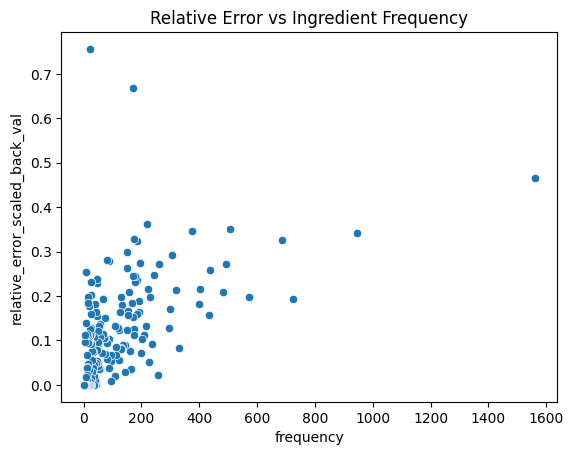

In [27]:
#ing_cat2 = ingredients_with_categories[["ingr_index", "frequency", "ingr", "food_category"]]
#print(ing_cat)
df_new['label'] = df_new['label'].astype(float)
merged_df2 = pd.merge(df_new, ingredients_with_categories, left_on='label', right_on = "ingr_index")
#print(merged_df2)


sns.scatterplot(data=merged_df2[merged_df2["epoch"]==30], x='frequency', y='relative_error_scaled_back_val')
plt.title("Relative Error vs Ingredient Frequency")
# Show the plot
plt.show()

In [28]:
df2 = merged_df2[merged_df2["epoch"]==30]
df2 = df2[["relative_error_scaled_back_val", "ingr", "frequency", "food_category", "freq_category", "mean_category", "cluster_category"]]
df2.to_csv('relative_error_vs_frequency.csv', index=False)

In [41]:
df2[df2["cluster_category"] == 6]

relative_error_scaled_back_val       ingr  frequency food_category  \
29                         0.46607  olive oil       1561   fat_and_oil   

    freq_category  mean_category  cluster_category  
29             10              6                 6

# Regression (not modified to 193 ingredients)

## Metrics

In [ ]:
# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
class self_MSE(tf.keras.metrics.Metric):
    """
    Calculates total MSE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MSE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mse_by_label_', **kwargs):
        super(self_MSE, self).__init__(name=name, **kwargs)
        # when scale is standardization, param1 is std, param2 is mean
        # when scale is normalization, param1 is min, param2 is max
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mse = self.add_weight(name='mse', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = tf.square(z_true - z_pred)
        mse = tf.reduce_mean(regression_loss, axis=0)
        self.mse.assign_add(mse)

    def result(self):
        return self.mse

    def reset_state(self):
        self.mse.assign(0.)

class self_MAE(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mae_by_label_', **kwargs):
        super(self_MAE, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mae = self.add_weight(name='mae', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = tf.abs(z_true - z_pred)
        mae = tf.reduce_mean(regression_loss, axis=0)
        self.mae.assign_add(mae)

    def result(self):
        return self.mae

    def reset_state(self):
        self.mae.assign(0.)


class self_relative_error(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, std, param1, param2, scale = "standardization", name='relative_error_by_label_', **kwargs):
        super(self_relative_error, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.std = std
        self.class_id = class_id
        self.relative_error= self.add_weight(name='relative_error', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = (tf.abs(z_true - z_pred))/ self.std[self.class_id]
        relative_error = tf.reduce_mean(regression_loss, axis=0)
        self.relative_error.assign_add(relative_error)

    def result(self):
        return self.relative_error

    def reset_state(self):
        self.relative_error.assign(0.)

## Compile and Fit Model

In [ ]:
input_shape = (75, 75, 3)

# Load the InceptionV3 model with pretrained weights
model = tf.keras.models.Sequential([
            InceptionV3(input_shape = input_shape, include_top=False, weights='imagenet',  pooling = "avg"),
            tf.keras.layers.Dense(10)
        ])  

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.0001, decay_steps=1000)
optimizer_adam_cos_decay = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
scaling_method = "normalization"
param1 = min_by_label
param2 = max_by_label
#Compile the model

model.compile(optimizer=optimizer_adam_cos_decay, loss = tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE), 
              metrics= [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mse_{}'.format(i)) for i in range(10)] +
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mae_{}'.format(i)) for i in range(10)] +
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = None, name='relative_error_{}'.format(i)) for i in range(10)] + 
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mse_scaled_back_{}'.format(i)) for i in range(10)]+
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mae_scaled_back_{}'.format(i)) for i in range(10)] +   
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = scaling_method, name='relative_error_scaled_back_{}'.format(i)) for i in range(10)]
              )

In [ ]:
EPOCHS = 30
#Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
44/44 [==============================] - 47s 149ms/step - loss: 0.1428 - mse_0: 3.9975 - mse_1: 4.0384 - mse_2: 5.5161 - mse_3: 3.9879 - mse_4: 2.8532 - mse_5: 2.8605 - mse_6: 3.3434 - mse_7: 3.3467 - mse_8: 2.7150 - mse_9: 3.4734 - mae_0: 6.9460 - mae_1: 6.8849 - mae_2: 8.0122 - mae_3: 6.6892 - mae_4: 5.8059 - mae_5: 6.0394 - mae_6: 6.6447 - mae_7: 6.4848 - mae_8: 5.6500 - mae_9: 5.7484 - relative_error_0: 4.7973 - relative_error_1: 2.6500 - relative_error_2: 0.1476 - relative_error_3: 0.4070 - relative_error_4: 84.3221 - relative_error_5: 0.2589 - relative_error_6: 0.3755 - relative_error_7: 0.1272 - relative_error_8: 0.5738 - relative_error_9: 0.3141 - mse_scaled_back_0: 869.3214 - mse_scaled_back_1: 2990.6934 - mse_scaled_back_2: 1194384.3750 - mse_scaled_back_3: 87765.2812 - mse_scaled_back_4: 1.6597 - mse_scaled_back_5: 147411.0469 - mse_scaled_back_6: 144588.6719 - mse_scaled_back_7: 692457.2500 - mse_scaled_back_8: 93343.2344 - mse_scaled_back_9: 303915.9375 - mae_sc

## Plot Results

In [ ]:
train_num_of_batch = math.ceil(len(X_train)/BATCH_SIZE)
val_num_of_batch = math.ceil(len(X_val)/BATCH_SIZE)
d = history.history
df_old = pd.DataFrame({'epoch':[],'mse_train':[],
                   'mse_val':[], 'mae_train':[],
                   'mae_val':[], 'mse_scaled_back_train':[],
                   'mse_scaled_back_val':[], 'mae_scaled_back_train':[],
                   'mae_scaled_back_val':[], 'relative_error_train':[], 'relative_error_val':[], 'relative_error_scaled_back_train':[], 
                   'relative_error_scaled_back_val':[], 'loss': [], 'val_loss':[],
                    'label':[]})

for idx in range(10):
    for ep in range(EPOCHS):
        
        mse_train = d['mse_{}'.format(idx)][ep]/train_num_of_batch
        mse_val = d['val_mse_{}'.format(idx)][ep]/val_num_of_batch
        mae_train = d['mae_{}'.format(idx)][ep]/train_num_of_batch
        mae_val = d['val_mae_{}'.format(idx)][ep]/val_num_of_batch
        mse_scaled_back_train = d['mse_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mse_scaled_back_val = d['val_mse_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        mae_scaled_back_train = d['mae_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mae_scaled_back_val = d['val_mae_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_train = d['relative_error_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_val = d['val_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_scaled_back_train = d['relative_error_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_scaled_back_val = d['val_relative_error_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        loss_train = d['loss'][ep]
        loss_val = d['val_loss'][ep]

        temp = pd.DataFrame({'epoch':[ep+1], 'mse_train':[mse_train],
                             'mse_val':[mse_val], 'mae_train':[mae_train],
                             'mae_val':[mae_val], 'mse_scaled_back_train':[mse_scaled_back_train],
                   'mse_scaled_back_val':[mse_scaled_back_val], 'mae_scaled_back_train':[mae_scaled_back_train],
                   'mae_scaled_back_val':[mae_scaled_back_val], 'relative_error_train':[relative_error_train], 'relative_error_val':[relative_error_val], 'relative_error_scaled_back_train':[ relative_error_scaled_back_train], 
                   'relative_error_scaled_back_val':[relative_error_scaled_back_val], 
                   'loss': [loss_train], 'val_loss':[loss_val],
                             'label':[idx+1]})
        df_old = df_old.append(temp, ignore_index=True)

df_old.label = df_old.label.astype(str)

<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

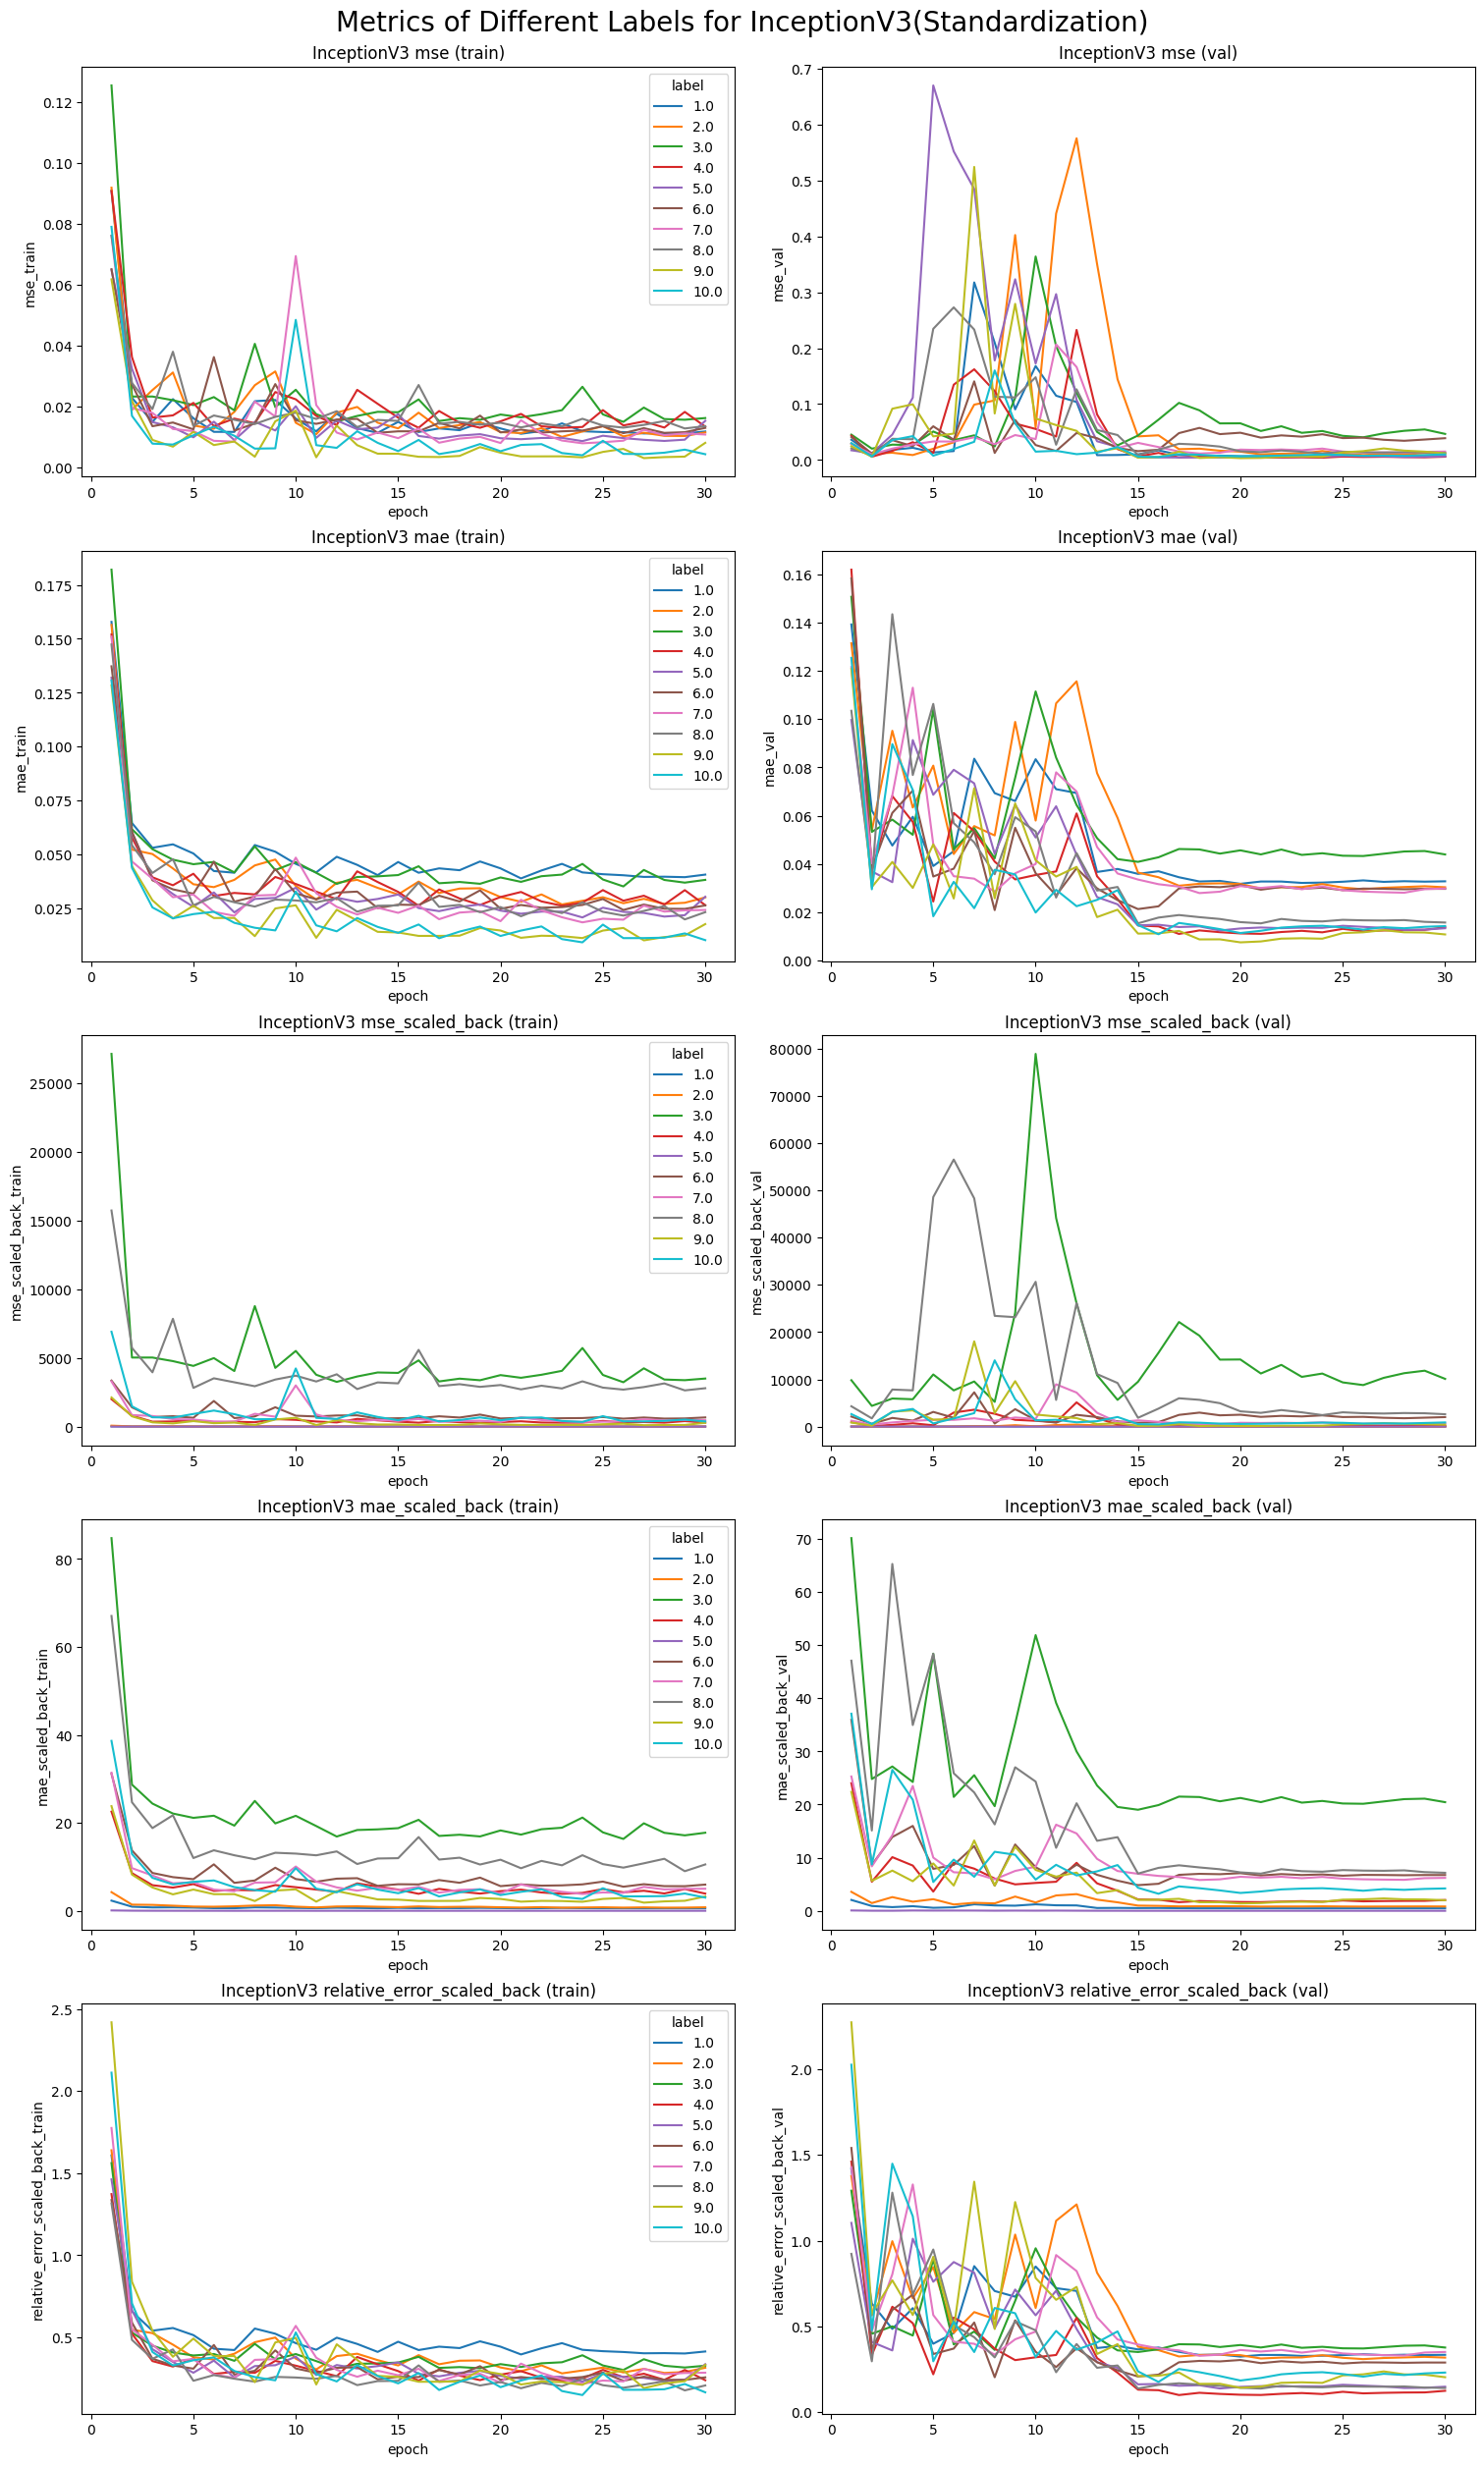

In [ ]:
import seaborn as sns
fig, axis = plt.subplots(5, 2, figsize=(15, 25), constrained_layout = True)
metrics = ["mse", "mae", "mse_scaled_back", "mae_scaled_back", "relative_error_scaled_back"]
datasets = ['train', 'val']
for i in range(5):
    for j in range(2):
        if j == 1:
            sns.lineplot(data=df_old, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=False, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))
        else:
            sns.lineplot(data=df_old, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=True, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))

fig.suptitle('Metrics of Different Labels for InceptionV3(Standardization)', fontsize=20);

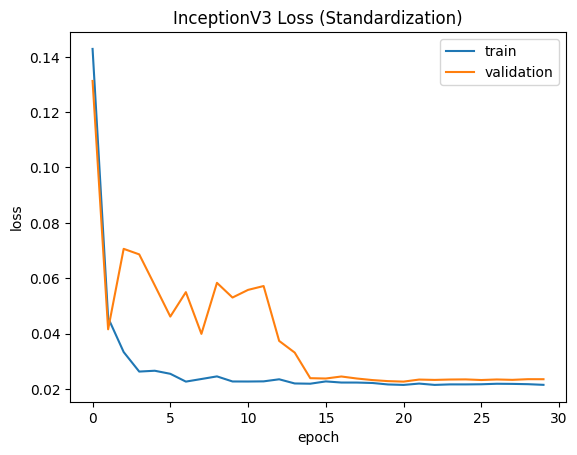

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Comparison

## After standarization

By comparing mse_scaled_back_val, mae_scaled_back_val, and relative_error_back_val from last epoch using old method(solely regression) and new method(classification + regression) using std-mean standardization, we can find that for label 1,2,4,5,7,8,10, the new method has smaller mse_scaled_back_val. For label 2,4,5,7,8,9,10, the new method has smaller mae_scaled_back_val. For label 2,4,7,8,9,10, the new method has smaller relative_error_back_val.

### Comparision of mse_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"]

29        1.480716
59        4.987154
89     3731.718750
119      90.415085
149       0.002425
179     564.501465
209     370.105469
239    1402.580322
269      89.972816
299     440.481171
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29        1.162285
59        4.442680
89     3310.386719
119      96.795181
149       0.002578
179     579.786377
209     295.215515
239     904.316040
269      91.163704
299     467.851440
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29     False
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269     True
299     True
Name: mse_scaled_back_val, dtype: bool

### Comparision of mae_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]

29      0.459477
59      0.652088
89     14.388117
119     1.457408
149     0.008356
179     4.135937
209     3.999250
239     5.332305
269     1.070906
299     2.461862
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      0.489606
59      0.639023
89     13.743342
119     1.520327
149     0.008619
179     4.249448
209     3.498826
239     3.539260
269     1.040579
299     2.632006
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      True
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269    False
299     True
Name: mae_scaled_back_val, dtype: bool

### Comparison of relative_error_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.317338
59     0.250992
89     0.265034
119    0.088667
149    0.121365
179    0.177333
209    0.225985
239    0.104585
269    0.108751
299    0.134513
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.338146
59     0.245963
89     0.253157
119    0.092495
149    0.125173
179    0.182200
209    0.197707
239    0.069417
269    0.105671
299    0.143810
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29      True
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269    False
299     True
Name: relative_error_scaled_back_val, dtype: bool

## After Normalization

For min-max Normalization, by comparing the metrics from last epoch, we can find that the old method outperform the new method in mse_scaled_back_val only for label 3 and 5, in mae_scaled_back_val and relative_error_scaled_back_val only for label 1 and 2. 

### Comparision of mse_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"]

29         1.518025
59         8.510077
89     10096.632812
119      128.651260
149        0.003852
179     2008.090210
209      650.520996
239     2610.391357
269      407.868011
299      880.105652
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29        5.235374
59        7.909443
89     4593.277344
119     110.734245
149       0.003187
179     497.731384
209     333.058807
239    1461.042480
269      89.976830
299     452.808136
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29      True
59     False
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: mse_scaled_back_val, dtype: bool

### Comparision of mae_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]

29      0.483859
59      0.825933
89     20.446560
119     2.041155
149     0.010201
179     6.740998
209     6.207372
239     7.160519
269     2.003433
299     4.220034
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      1.041490
59      0.909239
89     16.680567
119     1.646814
149     0.010026
179     3.891191
209     3.751297
239     4.829247
269     1.026562
299     2.447705
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]<= df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      True
59      True
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: mae_scaled_back_val, dtype: bool

### Comparison of relative_error_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.334177
59     0.317906
89     0.376632
119    0.124182
149    0.148161
179    0.289028
209    0.350759
239    0.140442
269    0.203450
299    0.230577
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.719305
59     0.349970
89     0.307261
119    0.100191
149    0.145609
179    0.166839
209    0.211974
239    0.094718
269    0.104248
299    0.133740
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29      True
59      True
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: relative_error_scaled_back_val, dtype: bool